# **Can We Predict Which Reviews are Trustworthy - Analyzing the Validity of Yelp Reviews**

*Team 7: Syed Ghalib Qadri,Tzu Ching Chou, Yutao Luo, Nan Dong, Xinyuan Xu*

**Dataset:** https://www.yelp.com/dataset

This dataset contains 6,990,280 records of yelp reviews from 150,346 different businesses

### Project Overview

**I.** Background    

**II.** Report Summary

**III.** Importing Data

**IV.**  Data Cleaning

**V.**  Exploratory Data Analysis

**VI.** Initial Questions about the Dataset

**VII.** Consolidating the Various Compliments Columns

**VIII.** Predicting which Reviews are given by Trustworthy Reviewers

**IX.** Conclusion

**X.** Challenges

**XI.** References








## I. Background

### I.I. Problem Definition and Objective:

For all reviews for business on Yelp, we will try to ascertain whether they are genuine reviews, or reviews given by trolls/bot accounts. To do this, we will be checking how the sort of ratings the account gives, the number of prior reviews it has given, the traction the account has. We will then be categorizing accounts as 'trustworthy' and 'non-trustworthy', the implication being that the 'non trustworthy' accounts are not reliable and might be trolls or spam accounts. Our next step will be to merge the tables togather, so each row in the review table can be classified as 'trustworthy' or 'non-trustworthy' on the basis of the user column. Lastly, our ultimate objective will be to create a machine learning model which can utilize features within a review to predict whether it is given by a 'trustworthy' account.


### I.II. Introduction and Motivation:

In today's day and age, information is often readily available. This also extends to the marketplace, where platforms such as Yelp (but also others for example facebook reviews, youtube vlogs, instagram influencers) provide potential customers with tremendous information about businesses. However while this knowledge is often taken for granted, there is always the issue of untrustworthy reviews, which might provide false information to customers.

There are many nonreliable reviews on online platforms, which worsens the consumer experience (for example by not choosing a genuinely good restaurant). Discarding unreliable reviews will allow consumers to make better-informed purchasing decisions when deciding on businesses, as reviews from troll/bot accounts will often shift the average rating for a business. Furthermore, seperating trustworthy and non-trustworthy reviews will also help businesses serve customer needs better, as this will allow them to gauge genuine customer concerns, as well as gain a good understanding of where they stand vis a vis customer expectations.

### I.III. Defining Untrustworthy Reviews:

While formally defined later in the project, on an intuitive level, untrustworthy reviews in this project are defined as those not provided by trustworthy accounts. These are reviews made in bad faith by troll accounts, or meant to promote businesses by spam/bot account. Thus our project will define these as untrustworthy reviews, and will define genuine reviews as trustworthy reviews.Thus we ignore the fact that trustworthy accounts might provide unreliable reviews (for example because of genuine bad taste on behalf of a user), and instead focus on the underlying motivations for providing a review. 

note: stars and ratings are used interchangebly, and mean the number of stars given (on a scale where 1 is the minimum and 5 is the maximum)

## II. Report Summary:

This projet file can be summarized as doing the following: 

1. Importing and Cleaning Data
2. Basic EDA and Data Manipulation
3. Questions on the Dataset: 
    - Distribution of reviews per year
    - Distribution of average ratings for businesses
    - Relationship between review count and average ratings
    - Distribution of likes when we remove unreliable
    - Geographic differences in reviews
    - Relationship between text length in a review and rating given
    - Relationship between number of fans and 'useful' given (linear regression)
    - Differences by account age
    - Relationship between review count and low average review score (linear regression)
4. Consolidating Compliments
5. Defining 'Trustworthy' users
6. Merging different datasets
7. Post merge Questions:
    - Differences between trustworthy and non trustworthy users.
    - Relationship between number of reviews and average rating (regression)
    - Most common words in positive and negative reviews.
8. Machine Learning model
    - Pipeline
    - Regression
    - Analysis
9. A brief overview of Challenges faced

As can be seen above, our main analysis dealt with consolidating the compliments columns, defining 'trustworthy' users, merging the datasets, and creating the Machine Learning model to predict which reviews are given by 'trustworthy' users. However, several of the other questions helped us understand more about the dataset, provided useful insights, or informed our decisions on how to answer our main questions.



## III. Importing Data:

In [1]:
#DATASET SCHEMA
from pyspark.sql import functions as F
from pyspark.sql.types import (StructType, 
                               StructField, 
                               DateType, 
                               BooleanType,
                               DoubleType,
                               IntegerType,
                               StringType,
                               FloatType,
                               DateType)

business_schema = StructType([StructField("address", StringType(), True),
                            StructField("business_id", StringType(), True),
                            StructField("categories", StringType(), True ),
                            StructField("city", StringType(), True),
                            StructField("name", StringType(), True),
                            StructField("postal_code", IntegerType(), True  ),
                            StructField("review_count", IntegerType(), True ),
                            StructField("stars", FloatType(), True ),
                            StructField("state", StringType(), True),
                            ])

review_schema = StructType([StructField("review_id", StringType(), True),
                            StructField("user_id", StringType(), True),
                            StructField("business_id", StringType(), True ),
                            StructField("stars", FloatType(), True),
                            StructField("date", DateType(), True),
                            StructField("text", StringType(), True  ),
                            StructField("useful", IntegerType(), True ),
                            StructField("funny", IntegerType(), True ),
                            StructField("cool", StringType(), True),
                            ])

user_schema = StructType([StructField("user_id", StringType(), True),
                            StructField("name", StringType(), True),
                            StructField("review_count", IntegerType(), True ),
                            StructField("yelping_since", DateType(), True),
                            StructField("friends", StringType(), True),
                            StructField("useful", IntegerType(), True  ),
                            StructField("funny", IntegerType(), True ),
                            StructField("cool", IntegerType(), True ),
                            StructField("fans", IntegerType(), True),
                            StructField("elite", IntegerType(), True),
                            StructField("average_stars", IntegerType(), True),
                            StructField("compliment_hot", IntegerType(), True),
                            StructField("compliment_more", IntegerType(), True),
                            StructField("compliment_profile", IntegerType(), True),
                            StructField("compliment_cute", IntegerType(), True),
                            StructField("compliment_list", IntegerType(), True),
                            StructField("compliment_note", IntegerType(), True),
                            StructField("compliment_plain", IntegerType(), True),
                            StructField("compliment_cool", IntegerType(), True),
                            StructField("compliment_funny", IntegerType(), True),
                            StructField("compliment_writer", IntegerType(), True),
                            StructField("compliment_photos", IntegerType(), True),
                            ])


In [2]:
data = "gs://is843-sg/notebooks/jupyter/yelp_data/"

In [3]:
#LOAD DATA


b_df = spark.read.format("json")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(data + "yelp_academic_dataset_business.json")

r_df = spark.read.format("json")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(data + "yelp_academic_dataset_review-001.json")

u_df = spark.read.format("json")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(data + "yelp_academic_dataset_user-002.json")




b_df.createOrReplaceTempView('b_df')
r_df.createOrReplaceTempView('r_df')
u_df.createOrReplaceTempView('u_df')





23/05/01 05:14:36 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
b_df.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [5]:
r_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [6]:
u_df.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [7]:
b_df.cache()
r_df.cache()
u_df.cache()

DataFrame[average_stars: double, compliment_cool: bigint, compliment_cute: bigint, compliment_funny: bigint, compliment_hot: bigint, compliment_list: bigint, compliment_more: bigint, compliment_note: bigint, compliment_photos: bigint, compliment_plain: bigint, compliment_profile: bigint, compliment_writer: bigint, cool: bigint, elite: string, fans: bigint, friends: string, funny: bigint, name: string, review_count: bigint, useful: bigint, user_id: string, yelping_since: string]

### III.I. Data Files:

In [11]:
b_df.limit(3).toPandas().head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,"1616 Chapala St, Ste 2","(None, None, None, None, None, None, None, Non...",Pns2l4eNsfO8kk83dixA6A,"Doctors, Traditional Chinese Medicine, Naturop...",Santa Barbara,None,0,34.426679,-119.711197,"Abby Rappoport, LAC, CMQ",93101,7,5.0,CA
1,87 Grasso Plaza Shopping Center,"(None, None, None, None, None, None, None, Non...",mpf3x-BjTdTEA3yCZrAYPw,"Shipping Centers, Local Services, Notaries, Ma...",Affton,"(8:0-18:30, 0:0-0:0, 8:0-14:0, None, 8:0-18:30...",1,38.551126,-90.335695,The UPS Store,63123,15,3.0,MO
2,5255 E Broadway Blvd,"(None, None, None, None, None, None, None, Tru...",tUFrWirKiKi_TAnsVWINQQ,"Department Stores, Shopping, Fashion, Home & G...",Tucson,"(8:0-23:0, 8:0-22:0, 8:0-23:0, 8:0-22:0, 8:0-2...",0,32.223236,-110.880452,Target,85711,22,3.5,AZ


In [12]:
r_df.limit(3).toPandas().head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,XQfwVwDr-v0ZS3_CbbE5Xw,0,2018-07-07 22:09:11,0,KU_O5udG6zpxOg-VcAEodg,3.0,"If you decide to eat here, just be aware it is...",0,mh_-eMZ6K5RLWhZyISBhwA
1,7ATYjTIgM3jUlt4UM3IypQ,1,2012-01-03 15:28:18,0,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,OyoGAe7OKpv6SyGZT5g77Q
2,YjUWPpI6HXG530lwP-fb2A,0,2014-02-05 20:30:30,0,saUsX_uimxRlCVr67Z4Jig,3.0,Family diner. Had the buffet. Eclectic assortm...,0,8g_iMtfSiwikVnbP2etR0A


In [13]:
u_df.limit(3).toPandas().head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,3.91,467,56,467,250,18,65,232,180,844,...,5994,2007,267,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",1259,Walker,585,7217,qVc8ODYU5SZjKXVBgXdI7w,2007-01-25 16:47:26
1,3.74,3131,157,3131,1145,251,264,1847,1946,7054,...,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",3138,"ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",13066,Daniel,4333,43091,j14WgRoU_-2ZE1aw1dXrJg,2009-01-25 04:35:42
2,3.32,119,17,119,89,3,13,66,18,96,...,1003,"2009,2010,2011,2012,2013",52,"LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",1010,Steph,665,2086,2WnXYQFK0hXEoTxPtV2zvg,2008-07-25 10:41:00


## IV. Data Cleaning

### IV.I. Number of rows in the 3 tables

In [14]:
print('There are {} rows in the business table'.format(b_df.count()))
print('There are {} rows in the review table'.format(r_df.count()))
print('There are {} rows in the user table'.format(u_df.count()))

There are 150346 rows in the business table


There are 6990280 rows in the review table


There are 1987897 rows in the user table


### IV.II. Dropping Duplicates

In [8]:
#Dropping duplicates if there are any
b_df = b_df.drop_duplicates()
r_df = r_df.drop_duplicates()
u_df = u_df.drop_duplicates()



### IV.III. Number of Missing Values in each Table

In [16]:
# Number of missing values for each column in business table
missing_count_business = [(c, b_df.filter(F.col(c).isNull()).count()) for c in b_df.columns]
missing_count_business

[('address', 0),
 ('attributes', 13744),
 ('business_id', 0),
 ('categories', 103),
 ('city', 0),
 ('hours', 23223),
 ('is_open', 0),
 ('latitude', 0),
 ('longitude', 0),
 ('name', 0),
 ('postal_code', 0),
 ('review_count', 0),
 ('stars', 0),
 ('state', 0)]

In [17]:
# Number of missing values for each column in review table
missing_count_review = [(c, r_df.filter(F.col(c).isNull()).count()) for c in r_df.columns]
missing_count_review

[('business_id', 0),
 ('cool', 0),
 ('date', 0),
 ('funny', 0),
 ('review_id', 0),
 ('stars', 0),
 ('text', 0),
 ('useful', 0),
 ('user_id', 0)]

In [18]:
# Number of missing values for each column in user table
missing_count_user = [(c, u_df.filter(F.col(c).isNull()).count()) for c in u_df.columns]
missing_count_user

[('average_stars', 0),
 ('compliment_cool', 0),
 ('compliment_cute', 0),
 ('compliment_funny', 0),
 ('compliment_hot', 0),
 ('compliment_list', 0),
 ('compliment_more', 0),
 ('compliment_note', 0),
 ('compliment_photos', 0),
 ('compliment_plain', 0),
 ('compliment_profile', 0),
 ('compliment_writer', 0),
 ('cool', 0),
 ('elite', 0),
 ('fans', 0),
 ('friends', 0),
 ('funny', 0),
 ('name', 0),
 ('review_count', 0),
 ('useful', 0),
 ('user_id', 0),
 ('yelping_since', 0)]

### IV.IV. Dropping Additional Columns

As we will not be conducting an extensive geographic analysis, we will be dropping columns such as address, longitude, postal code. Furthermore, we will be focusing on the user's and whether they are trustworthy or not, and thus will be dropping the business attributes, and operating hours columns.

In [11]:
#Dropping postal_code in business table
b_df = b_df.drop('address','latitude','longitude','postal_code','attributes','hours','is_open')


In [12]:
u_df = u_df.drop('elite','friends','name')

## V. Exploratory Data Analysis

### V.I. Summary Statistics of Important Features in the 3 tables

In [21]:
b_df.describe(['review_count','stars']).show()

+-------+------------------+------------------+
|summary|      review_count|             stars|
+-------+------------------+------------------+
|  count|            150346|            150346|
|   mean| 44.86656113232144|3.5967235576603303|
| stddev|121.12013570117077|0.9744207509201362|
|    min|                 5|               1.0|
|    max|              7568|               5.0|
+-------+------------------+------------------+



In [22]:
u_df.describe("average_stars","fans","review_count","useful").show()

+-------+------------------+------------------+------------------+-----------------+
|summary|     average_stars|              fans|      review_count|           useful|
+-------+------------------+------------------+------------------+-----------------+
|  count|           1987897|           1987897|           1987897|          1987897|
|   mean| 3.630494150350875|1.4657404282012598|23.394409267683386|42.29633527290398|
| stddev|1.1833369995975167|18.130752723855757| 82.56699161797873|641.4805967755898|
|    min|               1.0|                 0|                 0|                0|
|    max|               5.0|             12497|             17473|           206296|
+-------+------------------+------------------+------------------+-----------------+



In [23]:
u_df.selectExpr("min(yelping_since)", "max(yelping_since)").show()

+-------------------+-------------------+
| min(yelping_since)| max(yelping_since)|
+-------------------+-------------------+
|2004-10-12 08:46:11|2022-01-19 17:15:47|
+-------------------+-------------------+



In [24]:
summary_stats = r_df.select('cool', 'funny', 'useful').summary()

summary_stats.show()

+-------+------------------+-------------------+------------------+
|summary|              cool|              funny|            useful|
+-------+------------------+-------------------+------------------+
|  count|           6990280|            6990280|           6990280|
|   mean|0.4986175088837643|0.32655959417934616|1.1846089140921394|
| stddev|2.1724598202111847| 1.6887290985540464| 3.253766966933358|
|    min|                -1|                 -1|                -1|
|    25%|                 0|                  0|                 0|
|    50%|                 0|                  0|                 0|
|    75%|                 0|                  0|                 1|
|    max|               404|                792|              1182|
+-------+------------------+-------------------+------------------+



### V.II. Top 10 categories of businesses

In [25]:
from pyspark.sql.functions import split, explode
import matplotlib.pyplot as plt
import seaborn as sns

b_df = b_df.withColumn("category", explode(split(b_df.categories, ", ")))

category_counts = b_df.groupBy("category").count().orderBy("count", ascending=False)
category_counts.show()



+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|52268|
|                Food|27781|
|            Shopping|24395|
|       Home Services|14356|
|       Beauty & Spas|14292|
|           Nightlife|12281|
|    Health & Medical|11890|
|      Local Services|11198|
|                Bars|11065|
|          Automotive|10773|
|Event Planning & ...| 9895|
|          Sandwiches| 8366|
|American (Traditi...| 8139|
|         Active Life| 7687|
|               Pizza| 7093|
|        Coffee & Tea| 6703|
|           Fast Food| 6472|
|  Breakfast & Brunch| 6239|
|      American (New)| 6097|
|     Hotels & Travel| 5857|
+--------------------+-----+
only showing top 20 rows



### V.III. Correlation Matrix for the User Table

In [15]:
cols_to_corr = u_df['average_stars','cool','fans','funny','review_count','useful']
py_cols_to_corr = cols_to_corr.toPandas()
corr_matrix = py_cols_to_corr.corr()

print(corr_matrix)

               average_stars      cool      fans     funny  review_count  \
average_stars       1.000000  0.010437  0.019413  0.007060      0.045380   
cool                0.010437  1.000000  0.600828  0.964872      0.494112   
fans                0.019413  0.600828  1.000000  0.590613      0.534190   
funny               0.007060  0.964872  0.590613  1.000000      0.476440   
review_count        0.045380  0.494112  0.534190  0.476440      1.000000   
useful              0.010973  0.991841  0.643238  0.954307      0.573369   

                 useful  
average_stars  0.010973  
cool           0.991841  
fans           0.643238  
funny          0.954307  
review_count   0.573369  
useful         1.000000  


<AxesSubplot:>

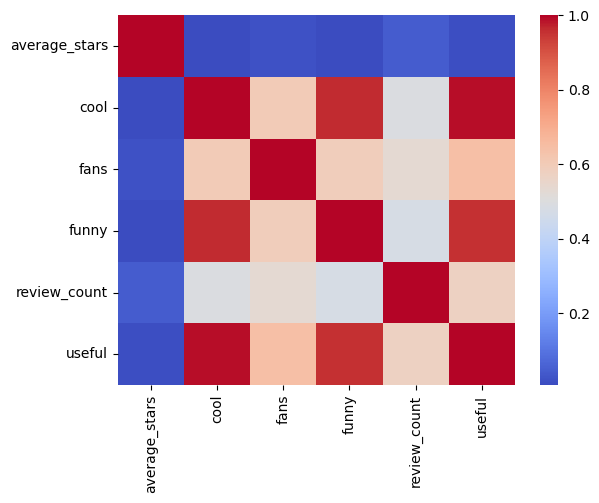

In [16]:
import seaborn as sns

sns.heatmap(corr_matrix, cmap='coolwarm')

Before identifying which users are trustworthy for the purposes of our analysis, it is essential to check the correlation between various variables in the user table. While we see here that average stars has a very weak corelation with all other variables, we also see that the other variables have strong correlation with each other as well as review count.

## VI. Initial Questions about the Dataset

With our EDA and Data Cleaning done, we will be exploring certain aspects of our data, before moving on to our main analysis. The visualizations below either helped us understand our dataset better or helped us to choose which features to use in our main analysis. 

### 1. What is the distribution of number of reviews per year?

In [40]:
reviews_per_year = r_df.groupBy(F.year("date").alias("Year")).agg(F.count("review_id").alias("review_count")).orderBy("Year")
reviews_per_year.show(25)

+----+------------+
|Year|review_count|
+----+------------+
|2005|         854|
|2006|        3853|
|2007|       15363|
|2008|       48226|
|2009|       74387|
|2010|      138587|
|2011|      230813|
|2012|      286570|
|2013|      383950|
|2014|      522275|
|2015|      688415|
|2016|      758882|
|2017|      820048|
|2018|      906362|
|2019|      907284|
|2020|      554557|
|2021|      618189|
|2022|       31665|
+----+------------+



In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [21]:
py_reviews_per_year = reviews_per_year.toPandas()
py_reviews_per_year.head(5)

,Year,review_count
0,2005,854
1,2006,3853
2,2007,15363
3,2008,48226
4,2009,74387


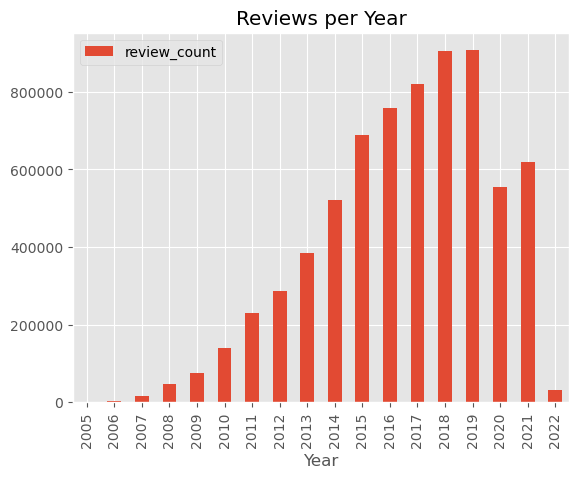

In [22]:
import pandas as pd

df_reviews_per_year = py_reviews_per_year.set_index("Year")

df_reviews_per_year[["review_count"]].plot.bar()
plt.title('Reviews per Year');

As part of our EDA, we also explored how the number of reviews given per year changed. We saw that the platform Yelp increased in popularity signficantly between 2007 and 2015, after which the number of reviews given slowed down, almost staying constant at ~900,000 in both years. 2021 and 2021 saw a shart fall from the 2019 peak due to the Covid-19 lockdowns which meant a lot of businesses were closed, and a lot of people were quarantining. The number for 2022 is small as the dataset was compiled in 2022, and thus did not capture all the reviews from within that year. 

### 2. What is the distribution of avg. ratings for businesses?

The average of the rating of the bussinesses are roughly 3.59. 

The review count distribution appears to be heavily skewed to the right, with the majority of businesses having fewer than 200 reviews, and a small number of businesses having very high review counts (over 4500). This distribution suggests that there are a few businesses that are extremely popular and receive a large number of reviews, while the vast majority of businesses receive only a handful of reviews. These businesses with high review counts could be considered outliers in the distribution.

This is important as business rating is one of the most important indicators for a customer on how good a business is. In the analysis directly below, we will see how this distribution changes when certain less reliable reviews are removed.



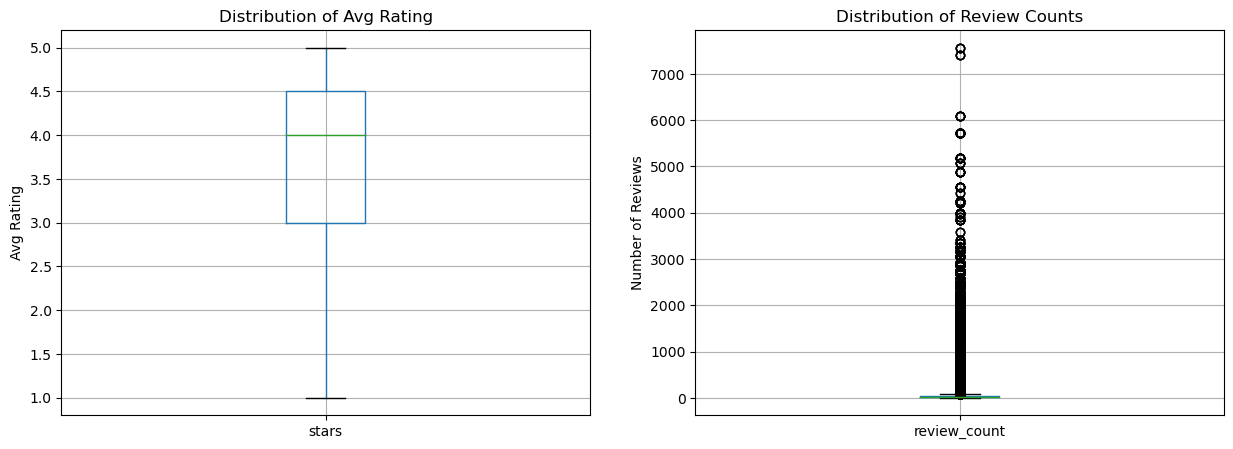

In [26]:
#Optional Graph

b_pd = b_df.select(["stars", "review_count"]).toPandas()


fig, ax = plt.subplots(1, 2, figsize=(15,5))

b_pd.boxplot("stars", ax=ax[0])
ax[0].set_title("Distribution of Avg Rating")
ax[0].set_ylabel('Avg Rating')

b_pd.boxplot(column=["review_count"], ax=ax[1])
ax[1].set_title("Distribution of Review Counts")
ax[1].set_ylabel('Number of Reviews')

plt.show()

### 3. What is the relationship between review count and average ratings?

Text(0, 0.5, 'Number of Reviews')

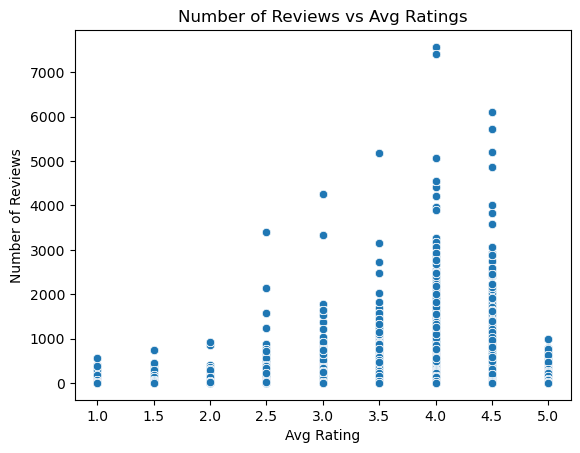

In [28]:
sns.scatterplot(b_pd,x='stars',y='review_count')
plt.title('Number of Reviews vs Avg Ratings')
plt.xlabel('Avg Rating')
plt.ylabel('Number of Reviews')

m, b = np.polyfit(x, y, 1)

The scatterplot shows that businesses with ratings from 2.5 to 4.5 have a higher number of reviews, ranging from 1000 to 7000+ reviews. For businesses that have a 5.0 rating, their number of revies range from 0 to 1000. This may be because the bussinesses with a 5.0 rating are new businesses that has only received 5.0 ratings from their customers. On the other hand Business that have a lower rating, 1.0 to 2.0, all have a low number of review, ranging from 0 to 1000 reviews. Overall, businesses with higher rating tend to have a higher number of reviews and vice versa for business with lower rating.

This analysis is important as it might mean that more popular restaurants are not impacted by spam/troll accounts as much which might also help explain their higher rating. When more reviews are given for a restaurant, the impact of troll/spam reviews might be diluted. 

### 4. What's the distribution of likes when we remove unreliable users' average rating? 


In [29]:
# Group the data by a column
avg_rate = u_df.groupby('average_stars')

# Compute an aggregate operation on the grouped data
aggregated_data = avg_rate.agg({'average_stars': 'count'})

# Sort the resulting DataFrame by the 'average_stars' column
sorted_data = aggregated_data.orderBy('average_stars')

sorted_data_de = aggregated_data.orderBy('average_stars', ascending=False)

sorted_data_de.show()

sorted_data.show(15)

+-------------+--------------------+
|average_stars|count(average_stars)|
+-------------+--------------------+
|          5.0|              356368|
|         4.99|                  35|
|         4.98|                 137|
|         4.97|                 247|
|         4.96|                 436|
|         4.95|                 706|
|         4.94|                 980|
|         4.93|                1193|
|         4.92|                1770|
|         4.91|                1423|
|          4.9|                1788|
|         4.89|                2287|
|         4.88|                3416|
|         4.87|                 830|
|         4.86|                4192|
|         4.85|                1352|
|         4.84|                 742|
|         4.83|                6004|
|         4.82|                1865|
|         4.81|                1272|
+-------------+--------------------+
only showing top 20 rows



+-------------+--------------------+
|average_stars|count(average_stars)|
+-------------+--------------------+
|          1.0|              165899|
|         1.01|                   1|
|         1.02|                   3|
|         1.03|                   5|
|         1.04|                  15|
|         1.05|                  17|
|         1.06|                  25|
|         1.07|                  31|
|         1.08|                  55|
|         1.09|                  48|
|          1.1|                  71|
|         1.11|                 108|
|         1.12|                  13|
|         1.13|                 152|
|         1.14|                 271|
+-------------+--------------------+
only showing top 15 rows



In [30]:
from pyspark.sql.functions import col

# The first filter is to filter out users who have less then 3 points or less then 50 fans or gain less than 50 useful
filtered_users_low = u_df.filter((col("average_stars") > 3) | (col("useful") >= 50) | (col('fans') >= 50))

# The second filter filtered people who gave 5 points but with less fans and less useful
filtered_users_after = filtered_users_low.filter((col("average_stars") < 5) | ((col("average_stars") == 5) & ((col("useful") >= 10) & (col('fans') >= 5))))
filtered_users_after.show()




+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+----+-----+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|fans|funny|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+----+-----+------------+------+--------------------+-------------------+
|         3.22|              0|              0|               0|             0|              0|              0|              1|                0|               0|       

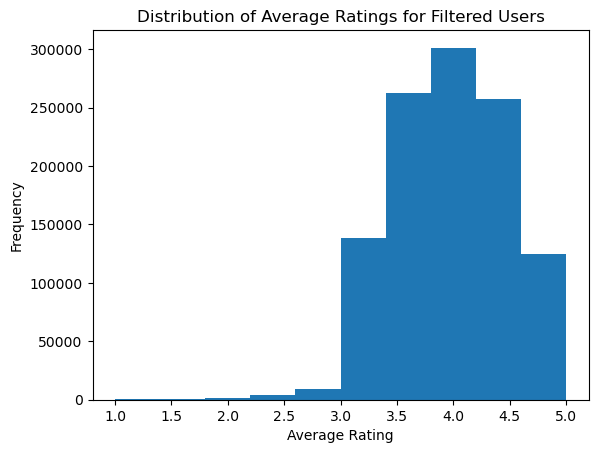

In [31]:
import matplotlib.pyplot as plt

# Select the average_stars column from the filtered_users_low DataFrame
average_stars_after_filter = filtered_users_after.select('average_stars').rdd.flatMap(lambda x: x).collect()

# Create a histogram with 10 bins
plt.hist(average_stars_after_filter, bins=10)

# Add x and y axis labels and a title
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Ratings for Filtered Users')

# Display the histogram
plt.show()

This is a precursor of our main analysis that we had completed earlier during our EDA phase. This analysis helped us identify the average rating for a user as being a key factor in the reliability of the review, i.e. we saw that if we exclude users who gave only very high (5) or very low (1) ratings (who would be unreliable users), there is a signficant impact on the ratins recieved by a business.

We could see that from the lists, there are more users tend to give 1.0 and 5.0, this may be caused by bots or people who intend to leave low or high points, for example like competitors or people from own stores. Therefore we placed some filters to filter out unreliable reviewers (those who have less fans or less 'useful' on their comments. After the filter, we could see less 5 rates and 1 rates. This is only a cursory analysis, but it shows the tremendous impact that even a few filters on reviews can cause. Hence why we wish to proceed with our final analysis on removing unreliable reviews. 

Compared to the graph above, we see that ratings are much higher (in the 3-5 range) once unreliable reviews are removed from the dataset.

### 5. Is there any relationship between location and average rating?

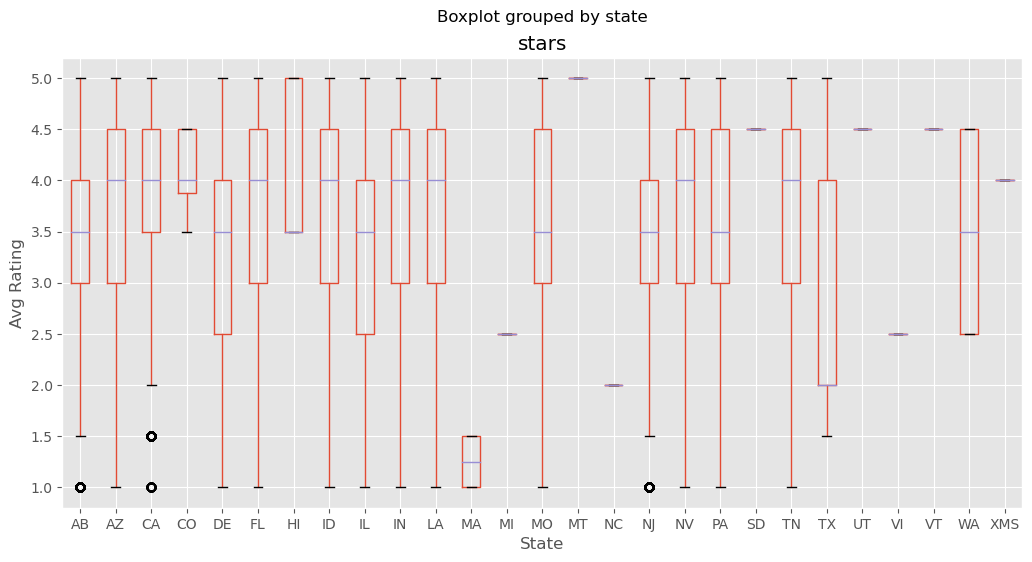

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

stars_by_state = b_df.select("state", "stars").toPandas()
stars_by_state.boxplot(by="state", figsize=(12, 6))
plt.xlabel("State")
plt.ylabel("Avg Rating")
plt.show()

While our initial assumption was that there might be little or no difference in average ratings for businesses based on their locations, what we see instead is that average ratings vary considerably based on location. Thus in our analysis, we can attempt to explore why such disparities exist, and what the distribition will look like once unreliable accounts are removed. 

Looking at this boxplot, we see that Massacheusets has one of the lowest average ratings, while Hawaii has the highest average ratings. Due to the nature of our main question, we decided not to explore deeper into location, however this analysis shows that signficant variations exist which might be useful for a seperate, location based study.

### 6. What is the relationship between the length of the 'text' in the reviews and the 'stars' rating?

In [33]:
# Add a new column 'text_length' for the length of the 'text' column
r_df = r_df.withColumn('text_length', F.length(r_df['text']))

# Group by 'stars' and calculate the average 'text_length'
avg_text_length_by_stars = r_df.groupBy('stars').agg(F.avg('text_length').alias('avg_text_length'))

# Show the result ordered by 'stars'
avg_text_length_by_stars.orderBy('stars').show()

+-----+------------------+
|stars|   avg_text_length|
+-----+------------------+
|  1.0| 713.7818675138678|
|  2.0| 721.0841411877113|
|  3.0| 669.1988094240202|
|  4.0| 587.5025328339245|
|  5.0|463.02431871004916|
+-----+------------------+



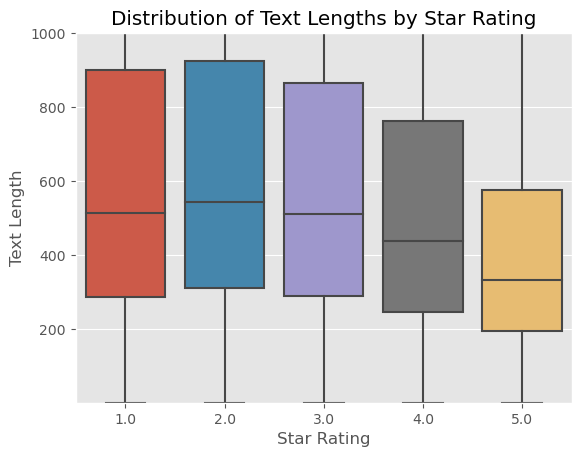

In [34]:
# Convert the data to a Pandas DataFrame
r_df_pd = r_df.select('stars', 'text_length').toPandas()

# Create a box plot
sns.boxplot(x='stars', y='text_length', data=r_df_pd)
plt.xlabel('Star Rating')
plt.ylabel('Text Length')
plt.title('Distribution of Text Lengths by Star Rating')

# Set the y-axis range from 1 to 1000
plt.ylim(1, 1000)

plt.show()

It shows a clear trend where Lower star ratings are linked to lengthier reviews, while higher star ratings are linked to shorter reviews. The greatest text lengths are typically seen in reviews with one and two stars, at 713.8 and 721.1 characters, respectively. The average text length reduces as the star rating rises, with reviews with three stars averaging 669.2 characters, reviews with four stars averaging 587.5 characters, and reviews with five stars having the least average text length at 463.0 characters. This shows that when providing lower ratings, reviewers often give more in-depth justifications or elaborate on their bad experiences, while positive reviews tend to be more concise.

This analysis is important as we can now gauge the quality of reviews based on the length of the text. Furthermore, the length of a text also explains customer behavior, more angry customers write longer reviews which correspond to a lower rating. However this analysis also shows that the length of text between different ratings given is very similar, and thus it might not be the best indicator of differentiating trustworthy reviews from non-trustworthy ones.

### 7. Are reviewers who give more useful more popular?

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [41]:
b_pd = u_df.select(["useful", "fans"]).toPandas()

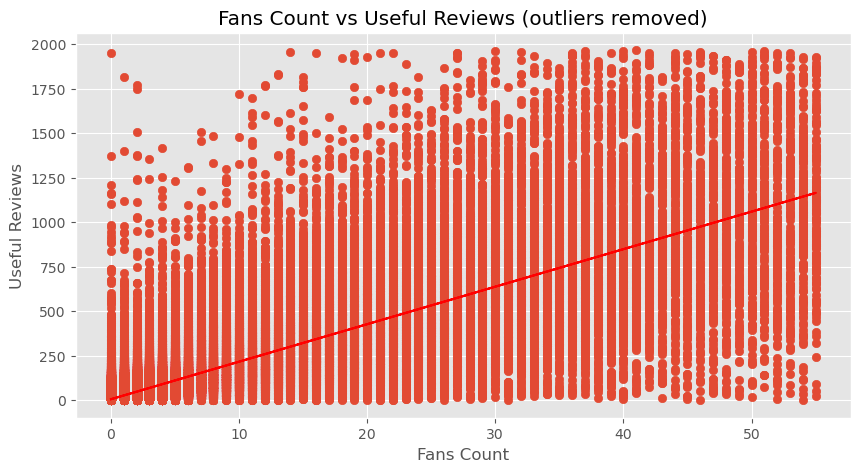

In [38]:
import numpy as np
from scipy import stats

b_pd = u_df.select(["useful", "fans"]).toPandas()

# Dropping all values which are 3 standard deviations from the mean.
z_scores = np.abs(stats.zscore(b_pd))
threshold = 3
b_pd = b_pd[(z_scores < threshold).all(axis=1)]

# Fitting a linear regression
x = b_pd["fans"]
y = b_pd["useful"]
m, b = np.polyfit(x, y, 1)

# Creating the scatter plot

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(x, y)
ax.plot(x, m*x + b, color="red")
ax.set_title("Fans Count vs Useful Reviews (outliers removed)")
ax.set_xlabel("Fans Count")
ax.set_ylabel("Useful Reviews")

plt.show()


In [39]:
import statsmodels.api as sm

# Fit the linear regression model
model = sm.OLS(y, x).fit()

# Print the summary of the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                 useful   R-squared (uncentered):                   0.734
Model:                            OLS   Adj. R-squared (uncentered):              0.734
Method:                 Least Squares   F-statistic:                          5.456e+06
Date:                Sat, 29 Apr 2023   Prob (F-statistic):                        0.00
Time:                        17:34:15   Log-Likelihood:                     -1.0463e+07
No. Observations:             1979239   AIC:                                  2.093e+07
Df Residuals:                 1979238   BIC:                                  2.093e+07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We want to check whether more popular reviewers are also the ones who flag more reviews as "useful". This is important as it helps can help us use number of useful likes given as a benchmark for how popular a reviewer is. While the graphs below (after outliers are removed), shows intuitively that a relationship exists, it is after we do the regression that we see that a positive relationship does exist. For every unit increase in fans, the number of useful rises by 21.4272, and as the p value < 0.05 this value is statistically signficant.

This is important as this shows that the people within the community often follow others who are more actively commenting and engaging in Yelp reviews. This in turn shows that a good indicator of how 'trustworthy' a user is might be how other reviews percieve them, as this graph shows that more helpful/engaged reviewers get more traction from the community. This then informed our decision to use some community-based metrics (number of fans, and number of compliments recieved from other reviewers) in determining whether  a review is trustworthy or not.

### 8. What is the average number of reviews given by each account age range?

Next we explore various factors related to the age of the accounts i.e how long has the account been active on Yelp since. 

In [9]:
from pyspark.sql.functions import to_date

u_df = u_df.withColumn('yelping_since_date', to_date('yelping_since', 'yyyy-MM-dd HH:mm:ss'))

from pyspark.sql.functions import current_date, datediff

u_df = u_df.withColumn('account_age', datediff(current_date(), 'yelping_since_date'))
u_df = u_df.filter(u_df.account_age >= 90)

In [10]:
u_df.select('account_age').distinct().show()


+-----------+
|account_age|
+-----------+
|       3794|
|       4900|
|       4818|
|       4519|
|       4935|
|       3997|
|       3918|
|       5518|
|       3749|
|       5156|
|       5300|
|       4101|
|       2122|
|       3175|
|       1645|
|       2659|
|       2366|
|       1580|
|       2866|
|       1829|
+-----------+
only showing top 20 rows



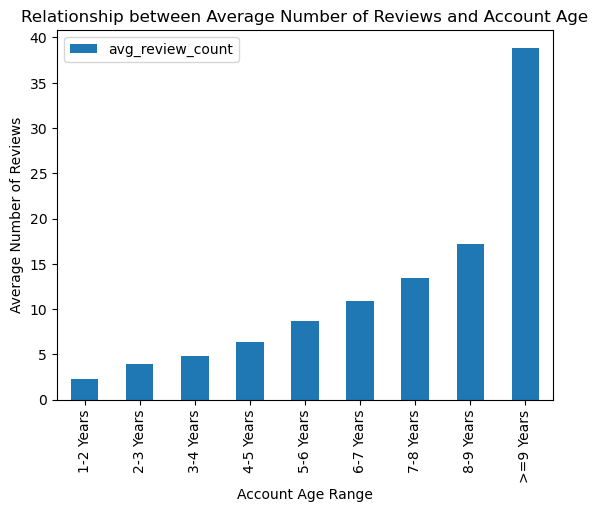

In [11]:
from pyspark.sql.functions import count

account_age_count = u_df.groupBy('account_age').agg(count('*').alias('review_count'))

from pyspark.sql.functions import count, when, datediff, current_date, udf, avg

# Define the age ranges
u_df = u_df.withColumn('account_age_years', (datediff(current_date(), 'yelping_since_date') / 365).cast('int'))
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 100]
labels = ['<1 Year', '1-2 Years', '2-3 Years', '3-4 Years', '4-5 Years', '5-6 Years', '6-7 Years', '7-8 Years', '8-9 Years', '>=9 Years']
u_df = u_df.withColumn('account_age_index', when(u_df.account_age_years < 1, 0).otherwise(when(u_df.account_age_years >= 9, 9).otherwise(u_df.account_age_years)))
u_df = u_df.withColumn('account_age_range', udf(lambda i: labels[i], StringType())('account_age_index'))
labels.insert(0, '<1 Year')
# Calculate the average number of reviews per account age range
account_age_avg = u_df.groupBy('account_age_range').agg(avg('review_count').alias('avg_review_count'))

# Convert to Pandas DataFrame for plotting
account_age_avg_pd = account_age_avg.toPandas().sort_values('account_age_range')

# Plot the results
import matplotlib.pyplot as plt
account_age_avg_pd.plot(kind='bar', x='account_age_range', y='avg_review_count')
plt.xlabel('Account Age Range')
plt.ylabel('Average Number of Reviews')
plt.title('Relationship between Average Number of Reviews and Account Age')
plt.show()


The graph shows the average number of reviews per account age range for the Yelp users in the dataset. From the graph, we can see that the average number of reviews increases with the age of the account. This trend is to be expected as older accounts have more time to accumulate reviews. Users who have been using Yelp longer are likely to spend more money in it and are therefore more likely to post reviews.

Overall, this chart provides valuable insight into Yelp user behavior, including the number of reviews they leave and how this behavior changes with the age of their account. This information can be used to better understand user behavior on the platform and to develop strategies to improve the quality of reviews.

### 9. How many total reviews are given by each account age range group?

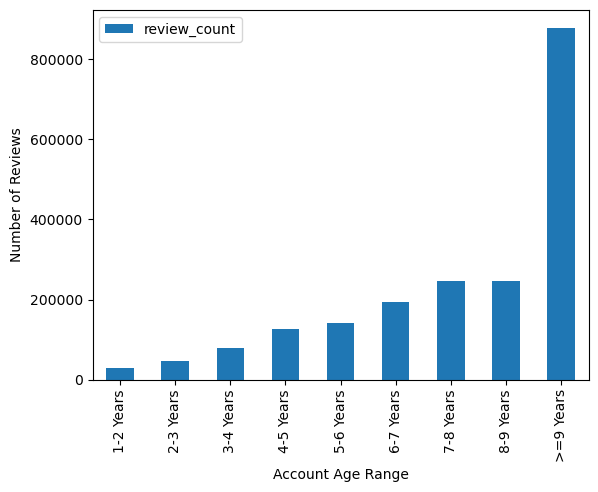

In [12]:
# Count the number of reviews from each account age range
account_age_count = u_df.groupBy('account_age_range').agg(count('*').alias('review_count'))

account_age_count_pd = account_age_count.toPandas().sort_values('account_age_range')

account_age_count_pd.plot(kind='bar', x='account_age_range', y='review_count')
plt.xlabel('Account Age Range')
plt.ylabel('Number of Reviews')
plt.show()

This graph is similar to the previous one, the graph shows the total number of reviews per account age range for the Yelp users in the dataset. From the graph, we can see that the total number of reviews increases with the age of the account.

The two graphs above show us that in both average, and in total, the older accounts have more reviews than younger ones. The second graph might be surprising, as one would expect total number of reviews to be higher for younger accounts due to more accounts in the younger brackets, however this is not the case. Furthermore, there is a large gap between accounts which are 8-9 years old, and accounts greater than 9 years old. Now that we have a good understanding of the number of reviews posted by each account age category, we will explore the average ratings given by each age category.


### 10. What is the distribution of ratings by account age?

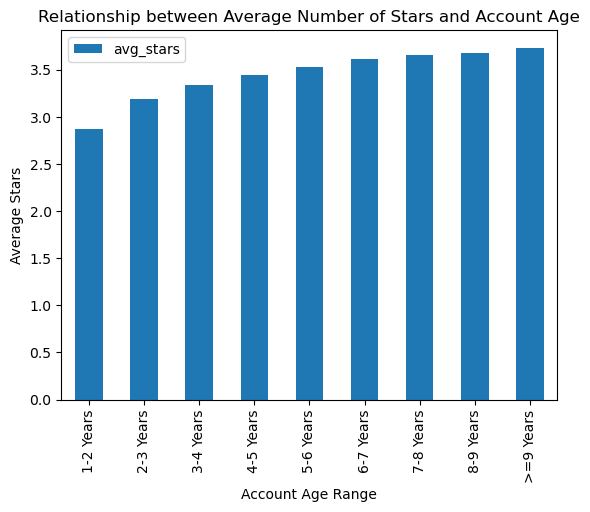

In [13]:
# Calculate the average stars per account age range
account_age_avg = u_df.groupBy('account_age_range').agg(avg('average_stars').alias('avg_stars'))

# Convert to Pandas DataFrame for plotting
account_age_avg_pd = account_age_avg.toPandas().sort_values('account_age_range')

# Plot the results
import matplotlib.pyplot as plt
account_age_avg_pd.plot(kind='bar', x='account_age_range', y='avg_stars')
plt.xlabel('Account Age Range')
plt.ylabel('Average Stars')
plt.title('Relationship between Average Number of Stars and Account Age')

plt.show()


This chart shows the average star rating for each account's age range. The overall trend in average star ratings appears to be higher for accounts in the older age ranges, while accounts in the 1-2 year age range show a significant decrease. The highest average star ratings are for accounts in the age range of nine years and older. This suggests that users who have been using Yelp longer are generally more positive about their reviews. However we also see that there is no signficant difference between accounts due to age, with all age categories giving between 2.9 and 3.6 average rating.

### 11. What is the relationship between review count and average rating for users who only give low ratings?

In [14]:
from pyspark.sql.functions import avg, sum
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt

# Filter reviews with low stars
negative_reviews = r_df.filter(r_df.stars < 3)

# Join user and review data
user_reviews = u_df.join(negative_reviews, "user_id", "inner")

# Cast review_count column to integer type
user_reviews = user_reviews.withColumn("review_count", user_reviews["review_count"].cast(IntegerType()))

# Calculate the average review score and review count for each user
user_review_avg = user_reviews.groupBy("user_id").agg(avg("stars").alias("avg_review"), sum("review_count").alias("total_reviews"))

user_review_avg.show()

+--------------------+------------------+-------------+
|             user_id|        avg_review|total_reviews|
+--------------------+------------------+-------------+
|--4AjktZiHowEIBCM...|               1.0|          114|
|--5EJ-TYQgbeViSGY...|               2.0|            1|
|--5_3gs0f24DZ7N2P...|               1.0|            2|
|--6lqYpHZCBbpW5z2...|               1.0|            9|
|--8r3pNaZiG1fN8LC...|               2.0|          125|
|--Al1VYjHegnOfTVo...|1.3333333333333333|          330|
|--DBsOOiMurIanfF2...|               2.0|           21|
|--Icfx-jxz715RfAa...|               1.0|            1|
|--RJK834fiQXm21Vp...|               1.0|            1|
|--Vu3Gux9nPnLcG9y...|               1.0|          406|
|--cPqjzKHqHKmGala...|               2.0|          147|
|--hhXCBjt6iPENfaM...|               1.0|           44|
|--oudE7FwOXwN8o_b...|               1.0|            2|
|--pZFwTybI_5-OhXw...|               1.0|           29|
|--pvE2eu3WWwikKs1...|               1.5|       

In [15]:
user_review_avg = user_review_avg.cache()

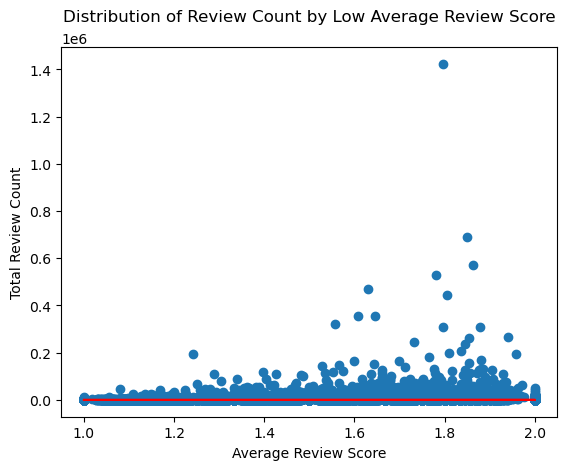

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

user_review_avg_pd = user_review_avg.toPandas()

plt.scatter(user_review_avg_pd["avg_review"], user_review_avg_pd["total_reviews"])
plt.title("Distribution of Review Count by Low Average Review Score\n")
plt.xlabel("Average Review Score")
plt.ylabel("Total Review Count")

# Regression Line
slope, intercept, r_value, p_value, std_err = stats.linregress(user_review_avg_pd["avg_review"], user_review_avg_pd["total_reviews"])
line = slope * user_review_avg_pd["avg_review"] + intercept
plt.plot(user_review_avg_pd["avg_review"], line, color='r')

plt.show()

In [17]:
print("Regression line equation: y = {:.2f}x + {:.2f}".format(slope, intercept))
print("R-squared value:", r_value**2)


Regression line equation: y = 208.45x + -151.05
R-squared value: 0.0010756722316582516


We filter reviews with low stars (less than 3) and join user and review data. The resulting DataFrame is used to calculate the average review score and number of reviews for each user.
We want to identify users who have given low reviews in the past and users with high review counts, as they may be fake reviews. This information helps identify potential troll accounts, or users who generate a lot of fake reviews.

However, when conducting our analysis and running a regression on the total review count and average review scores of users who only give low reviews, we see that almost no relationship exists between the number of reviews given, and the average review score. The R2 value is a little over 0.001 which means that almost none of the variation in the dependent variable is explained by the independent variable. This might be due to exclusively low reviews given by not just by troll accounts, but also genuine accounts who might only go through the effort of giving a review when they are thoroughly dissapointed by a business. As shown here, these might be users who give only very few reviews in total.

## VII. Consolidating the Various Compliments Columns

Out next step is to consolidate all the different "compliments" columns into a single compliment column. This will allow us view the sum of all compliments that a user has recieved, and also simplify our dataset by aggregating 12 columns into one.

### VII.I. Defining 'Trustworthy' Reviews: 

To understand the relationship between different features in reviews, and whether those reviews were 'trustworthy', we need to first define what a trustworthy review is. As we are trying to distinguish between genuine accounts and reviews given by troll or bot accounts, we will focus on the trustworthiness of the account/user to determine the trustworthiness of a review. 

A 'trustworthy' user can be defined as someone who:
- Has more than 10 fans, or
- Has given more than 10 reviews, or
- Has given non extreme reviews (greater than 1.2 or less than 4.8, the intuition beingthat troll or bot accounts will only give the max or min rating possible), or
- Has a 'compliments' greater than the average compliments given to the average user.

These criteria suggest that a trustworthy user is someone who has a significant following and whose reviews have been deemed helpful by others on the platform. It should also be noted that we are using a very lenient criteria for defining trustworthy users. The reason being that we are placing an emphasis on ensuring that genuine reviews are not deemed as untrustworthy. Furthermore, most of our metrics are using other user's opinions of users to identify whether they are trustworthy or not. 

Our first step will be to sum all the compliments columns into one column, which will be the total of all the compliments a user has recieved.

### VII.II. Importance of Identifying Trustworthy Reviews
Identifying trustworthy users is important for several reasons:

- Improved decision-making: Trustworthy user reviews can help consumers make better-informed decisions about products and services, leading to higher satisfaction levels.
- Enhanced review quality: Trustworthy users contribute to the overall quality of reviews on a platform, as their reviews are more likely to be accurate, relevant, and helpful (Mudambi & Schuff, 2010).
- Reduced deception and bias: Identifying trustworthy users can help filter out potentially deceptive or biased content, ensuring that users have access to reliable information.
- Fans: Users with more fans are likely to be more influential and provide better-quality reviews (Lu et al., 2012).
- Useful votes: Users with a higher number of 'useful' votes suggest their reviews are more helpful and informative (Ghose & Ipeirotis, 2011).
- Review count: Users who have written a higher number of reviews might be more experienced and thus provide more reliable feedback.
- Average star rating: Users who provide a balanced distribution of ratings might be more objective and less biased (Ghose & Ipeirotis, 2011).
- Compliments received: Users who receive many compliments on their reviews might be considered more trustworthy as their feedback is appreciated by others on the platform (Lu et al., 2012).
- Account age: Users with older accounts might be considered more trustworthy as they have a longer history on the platform and potentially more experience in providing reviews (Forman et al., 2008).

### VII.III. Analysis of Trustworthy and Non-Trustworthy Users

After our initial Data Cleaning, EDA, and Analysis is complete, we will list all the tables again, to show what columns we have in each table. 

In [10]:
b_df.limit(3).toPandas().head()

,business_id,categories,city,name,review_count,stars,state
0,NNcqCDV6PHhDmKY8fO6S9g,"Home Window Tinting, Car Window Tinting, Auto ...",Largo,Reeder's Auto Tint & Ceramic Coatings,27,4.5,FL
1,d45ejuYD188Yzyxz6cCu-g,"Home & Garden, Home Decor, Mattresses, Shoppin...",Nashville,Mattress Firm West End Avenue,6,4.5,TN
2,FLsMpCzvopg6vl3atsKVmQ,"Nutritionists, Weight Loss Centers, Health & M...",New Hope,Functional Life,5,5.0,PA


In [11]:
u_df.limit(3).toPandas().head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,fans,funny,review_count,useful,user_id,yelping_since
0,4.09,1346,61,1346,1400,24,62,413,114,730,93,439,3026,90,2486,532,3401,coKnuxLznH0FHb34m4ZLCw,2010-01-19 08:03:08
1,4.11,41,2,41,18,2,10,17,31,36,8,17,890,53,546,879,1423,rVxwIq-GU98GC2xMulsSqw,2009-01-13 05:12:30
2,4.08,6,1,6,2,1,0,2,1,3,0,3,125,16,79,126,241,afEBLpcr3rZNVdYnQGf46A,2009-07-29 23:57:22


In [13]:
r_df.limit(3).toPandas().head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,Cu8ysHKiZmJKRY9nF3Hzsw,0,2016-10-26 15:25:30,0,rHrhsfMGmYfCGiN8Ul02qQ,5.0,"These guys do good work, on time, and warranty...",0,x67HAnA_-ukgw9qwyMVOhQ
1,eL4lyE7LNoXEMvpcJ8WNVw,0,2011-08-25 16:14:24,0,dpgq69tsI2f_GpRH71hQsA,3.0,This was a tough one! On the merits of the w...,5,Uk3X2AypU8AqvcYEVf7s6Q
2,EqEcDeXqIq1YwnzHg_ZUFw,0,2016-06-11 20:57:20,0,p8y5nanIxGGzAAqiCuxBdA,1.0,Similar experience at this place ..gelato is g...,4,CysTz612pTix75Fye6-D4Q


### VII.IV. Merging All Compliment Columns in one Columns in the user table: 

In [9]:
compliment_cols = [F.col(c) for c in u_df.columns if c.startswith("compliment_")]
u_df = u_df.withColumn("compliments", sum(compliment_cols))

u_df.show(5)


+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+--------------------+----+--------------------+-----+---------+------------+------+--------------------+-------------------+-----------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|               elite|fans|             friends|funny|     name|review_count|useful|             user_id|      yelping_since|compliments|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+--------------------+----+--------------------+-----+---------+------------+------+--------------------+----------

In [10]:
compliment_cols = [c for c in u_df.columns if c.startswith("compliment_")]
u_df = u_df.drop(*compliment_cols)

u_df.show(5)

+-------------+----+---------+----+--------------------+-----+-------+------------+------+--------------------+-------------------+-----------+
|average_stars|cool|    elite|fans|             friends|funny|   name|review_count|useful|             user_id|      yelping_since|compliments|
+-------------+----+---------+----+--------------------+-----+-------+------------+------+--------------------+-------------------+-----------+
|         3.22|   5|         |   0|wGLl8K1t1Yp3bRjOs...|    8|Patrick|          49|    47|ba4oxq99fm4MPJMbY...|2012-01-01 20:58:48|          1|
|         4.18|   2|         |   1|_7bYeYvmC1fLWWjem...|    1|  Steve|          34|    27|fKeYEcuWYUrXWtnEN...|2010-07-16 11:40:36|          8|
|         3.07|  11|         |   1|hiA2p1Ou_WeGPdCzv...|   23| Sandra|          43|    42|5ZateMRJwVx4Jwi5m...|2008-06-16 18:12:13|          5|
|         4.06|  15|2018,2019|   3|-ZR3RjSskxwSY3siD...|    9|  Chris|          49|    28|njcsaHNBbLFkWMf47...|2012-06-06 22:15:17|     

In [11]:
avg_stars = u_df.select(F.avg('average_stars')).collect()[0][0]
avg_compliments = u_df.select(F.avg('compliments')).collect()[0][0]

u_df = u_df.withColumn('trustworthy',
                F.when((F.col('fans') > 10) | 
                     ((F.col('average_stars') < 4.8) & (F.col('average_stars') > 1.2)) |
                      (F.col('review_count') > 10) |
                     (F.col('compliments') > avg_compliments), 1)
               .otherwise(0))

               
b_df.createOrReplaceTempView('business_df')
r_df.createOrReplaceTempView('review_df')
u_df.createOrReplaceTempView('user_df')


In [16]:
u_df.show(3)

+-------------+----+----+-----+------------+------+--------------------+-------------------+-----------+-----------+
|average_stars|cool|fans|funny|review_count|useful|             user_id|      yelping_since|compliments|trustworthy|
+-------------+----+----+-----+------------+------+--------------------+-------------------+-----------+-----------+
|          5.0|   0|   1|    0|           1|     0|BCByLyy7qlKxNyZun...|2015-09-28 22:05:08|          0|          0|
|         3.75|   1|   1|    1|           3|     5|sH0xyz54Msz78O--t...|2014-11-26 01:33:06|          0|          1|
|         4.29|   2|   0|    0|          17|     2|ctVEAeW0c0B1La3t4...|2015-07-09 01:58:53|          0|          1|
+-------------+----+----+-----+------------+------+--------------------+-------------------+-----------+-----------+
only showing top 3 rows



### 12. What is the distribution of trustworthy and non-trustworthy users?

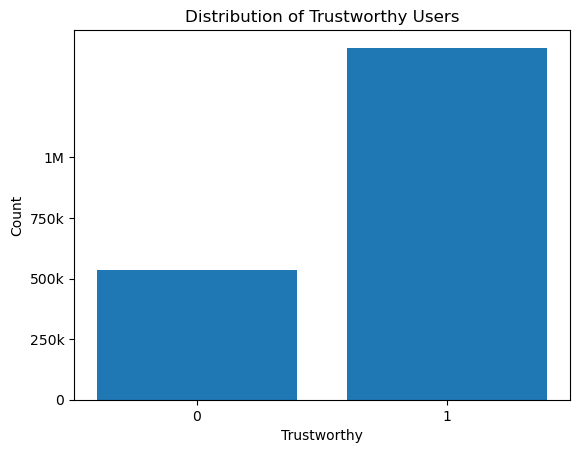

In [76]:
import matplotlib.pyplot as plt
trustworthy_dist = u_df.groupBy('trustworthy').count().toPandas()
plt.bar(trustworthy_dist['trustworthy'], trustworthy_dist['count'])
plt.xlabel('Trustworthy')
plt.ylabel('Count')
plt.title('Distribution of Trustworthy Users')
plt.xticks([0,1])
plt.yticks([0, 250000, 500000, 750000, 1000000, 1250000, 1500000, 1750000 ], ['0', '0.25M', '0.50M', '0.75M', '1.00M', '1.25M', '1.50M', '1.75M'])
plt.show()

The above plot shows us the count of trustworthy and non trustworthy reviewers/users. Here we see that, as a result of our criteria, there are approximately 500K untrustworthy reviewers, and about ~1.5 Million trustworthy reviewers. Thus we see that even with our lenient criteria, over 500,000 reviewers were classified as untrustowrthy. 

Next we will explore the distribution of ratings by trustworthy and untrustworthy reviewers.

### Merging the Datasets:

In [12]:
joined_df = u_df.join(r_df, "user_id")
joined_df.show(1)

+--------------------+-------------+----+-----+----+-------+-----+-----+------------+------+-------------------+-----------+-----------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+
|             user_id|average_stars|cool|elite|fans|friends|funny| name|review_count|useful|      yelping_since|compliments|trustworthy|         business_id|cool|               date|funny|           review_id|stars|                text|useful|
+--------------------+-------------+----+-----+----+-------+-----+-----+------------+------+-------------------+-----------+-----------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+
|--RJK834fiQXm21Vp...|          2.5|   0|     |   0|   None|    0|Renee|           1|     0|2018-02-04 20:34:16|          0|          1|aIoUwpy5ZFQXUDxWM...|   0|2019-08-25 23:17:52|    0|QPF7spAqCc-D81GeX...|  1.0|There are new own...|     0|
+--------------------+--

### 13. How does considering only Trustworthy Reviews change the ratings for Businesses?

In [13]:
# drop repeated col

joined_df = joined_df.drop(u_df.useful)
joined_df = joined_df.drop(u_df.cool)
joined_df = joined_df.drop(u_df.funny)

In [14]:
from pyspark.sql.functions import when
from pyspark.sql.functions import col

In [15]:
joined_df[["trustworthy", "fans","cool","useful",'average_stars','funny']].describe().toPandas()

,summary,trustworthy,fans,cool,useful,average_stars,funny
0,count,6990247,6990247,6990247,6990247,6990247,6990247
1,mean,0.8984479375335378,13.2091611355078,0.49861986278882564,1.1846145064687985,3.7464901082883735,0.3265611358225253
2,stddev,0.30205836212168435,87.23712982955027,2.172464678016826,3.2537736292002304,0.861798914531179,1.6887329356207266
3,min,0,0,-1,-1,1.0,-1
4,max,1,12497,404,1182,5.0,792


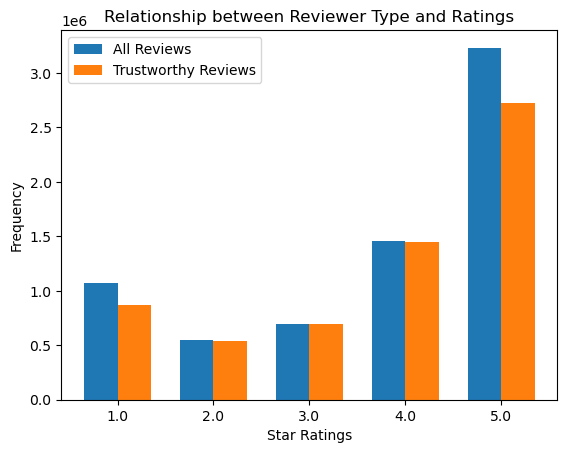

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Filter the combined_df based on the 'Trustworthy' column
trustworthy_reviews = joined_df.filter(joined_df['trustworthy'] == 1)

# Calculate star frequencies for both groups
all_star_freq = joined_df.groupBy('stars').count().sort('stars')
trustworthy_star_freq = trustworthy_reviews.groupBy('stars').count().sort('stars')

all_star_freq_pd = all_star_freq.toPandas()
trustworthy_star_freq_pd = trustworthy_star_freq.toPandas()

fig, ax = plt.subplots()
bar_width = 0.35

# Setting x-axis values
x_values = np.arange(len(all_star_freq_pd))

# Plotting the bar chart
ax.bar(x_values - bar_width / 2, all_star_freq_pd['count'], bar_width, label='All Reviews')
ax.bar(x_values + bar_width / 2, trustworthy_star_freq_pd['count'], bar_width, label='Trustworthy Reviews')

# Set x-axis labels
ax.set_xticks(x_values)
ax.set_xticklabels(all_star_freq_pd['stars'])

# Set x-axis and y-axis labels
ax.set_xlabel('Star Ratings')
ax.set_ylabel('Frequency')

ax.legend()
plt.title('Relationship between Reviewer Type and Ratings')
plt.show()


Star ratings 1 and 5: The frequencies of both 1-star and 5-star ratings are slightly lower in the trustworthy reviews compared to all reviews. This suggests that there might be some unreliable or potentially biased reviews at both extremes, which could be either excessively negative or overly positive. These extreme reviews may skew the overall distribution and could potentially misrepresent the true quality of the businesses.

Star ratings 2, 3, and 4: The frequencies of 2-star, 3-star, and 4-star ratings are almost the same for both all reviews and trustworthy reviews. This indicates that the middle ratings are relatively stable and consistent between the two groups. It suggests that these ratings might be less affected by unreliable or biased reviews, and they could provide a more accurate representation of the restaurants' quality. Thus when untrustworthy users are excluded, the extreme ends (ratings of 5 and 1) reduce, giving a more nuanced and balanced picture of the quality of various businesses.

### 14. How does the number of reviews written by a user relate to their average rating given?

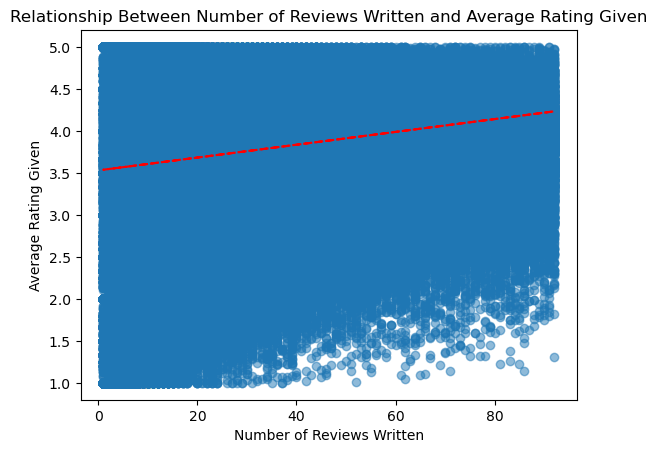

In [21]:
# Correcting for outliers

import numpy as np
import matplotlib.pyplot as plt

user_review_count_avg_stars = u_df.select("review_count", "average_stars")

user_review_count_avg_stars_pd = user_review_count_avg_stars.toPandas()

q5, q95 = np.percentile(user_review_count_avg_stars_pd, [5, 95], axis=0)

mask = (user_review_count_avg_stars_pd['review_count'] >= q5[0]) & (user_review_count_avg_stars_pd['review_count'] <= q95[0]) & (user_review_count_avg_stars_pd['average_stars'] >= q5[1]) & (user_review_count_avg_stars_pd['average_stars'] <= q95[1])
user_review_count_avg_stars_pd = user_review_count_avg_stars_pd[mask]

plt.scatter(user_review_count_avg_stars_pd['review_count'], user_review_count_avg_stars_pd['average_stars'], alpha=0.5)

plt.xlabel('Number of Reviews Written')
plt.ylabel('Average Rating Given')
plt.title('Relationship Between Number of Reviews Written and Average Rating Given')

#adding a regression line:
z = np.polyfit(user_review_count_avg_stars_pd['review_count'], user_review_count_avg_stars_pd['average_stars'], 1)
p = np.poly1d(z)
plt.plot(user_review_count_avg_stars_pd['review_count'],p(user_review_count_avg_stars_pd['review_count']),"r--")

plt.show()


The scatter plot helps visualize the distribution of user behavior in terms of review-writing frequency and the average rating given. The majority of users tend to write a smaller number of reviews (up to 5000) and give ratings within the 3.0 to 4.5 range. This may indicate that users are generally satisfied with the businesses they review, or they might be more inclined to write reviews when they have a relatively positive experience.

Furthermore, correcting for outliers shows us that generally a positive relationship exists between the number of reviews given and the aeverage rating given by users. THis means that users who give more reviews generally give higher ratings too. This validates our decision to include number of reviews as a factor in determining 'trustworthiness' of a user, as higher reviewrs are less likely to be troll accounts.

### 15. What are the most common words used in positive (4-5 stars) and negative (1-2 stars) reviews?

In [39]:
# Filter reviews by star ratings

positive_reviews = combined_df.filter(combined_df['stars'] >= 4)
negative_reviews = combined_df.filter(combined_df['stars'] <= 2)

In [40]:
# Tokenize the review text

from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="text", outputCol="words")
positive_words = tokenizer.transform(positive_reviews)
negative_words = tokenizer.transform(negative_reviews)

In [41]:
# Remove stop words

from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
positive_filtered = remover.transform(positive_words)
negative_filtered = remover.transform(negative_words)

In [42]:
# Count word frequencies

from pyspark.sql.functions import explode, count

positive_word_freq = positive_filtered.select(explode("filtered_words").alias("word")).groupBy("word").agg(count("*").alias("frequency")).sort("frequency", ascending=False)
negative_word_freq = negative_filtered.select(explode("filtered_words").alias("word")).groupBy("word").agg(count("*").alias("frequency")).sort("frequency", ascending=False)

In [54]:
positive_word_freq = positive_word_freq.cache()
negative_word_freq = negative_word_freq.cache()

In [55]:
positive_word_freq_pd = positive_word_freq.toPandas()
negative_word_freq_pd = negative_word_freq.toPandas()

In [63]:
positive_word_freq_pd.head(2)

,word,frequency
0,,12031947
1,great,2089531


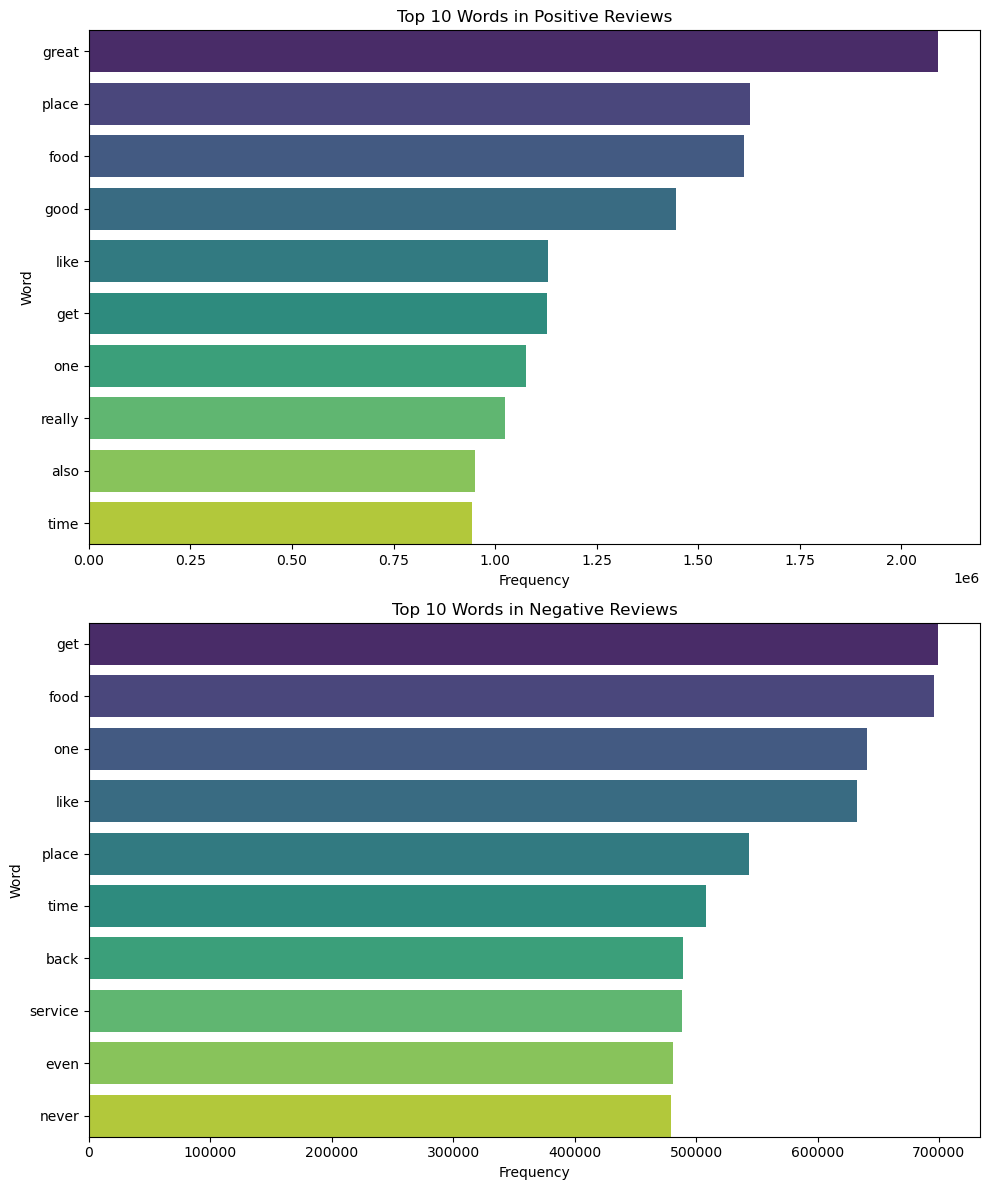

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting top 10 words from dataframes
top10_pos = positive_word_freq_pd.iloc[1:11]
top10_neg = negative_word_freq_pd.iloc[1:11]

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

sns.barplot(x='frequency', y='word', data=top10_pos, ax=ax[0], palette="viridis")
ax[0].set_title("Top 10 Words in Positive Reviews")
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Word")

sns.barplot(x='frequency', y='word', data=top10_neg, ax=ax[1], palette="viridis")
ax[1].set_title("Top 10 Words in Negative Reviews")
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Word")

ax[0].autoscale(enable=True, axis='y', tight=True)
ax[1].autoscale(enable=True, axis='y', tight=True)

plt.tight_layout()
plt.show()


In the analysis of positive comments (4-5 stars), the top ten most frequently used words were: great, place, food, good, like, get, one, really, also, and time. The word 'great' appeared as the most commonly used term, with a total count of 2,089,531 occurrences.

On the other hand, in the negative comments (1-2 stars), the top ten words used were: get, food, one, like, place, time, back, service, even, and never. The most frequently used words in this category were 'get' and 'food', both of which had over 700,000 occurrences.

According to the analysis, the positive reviews often emphasize the quality of the experience, as evidenced by the frequent use of words like 'great', 'good', and 'really'. In contrast, negative reviews tend to focus on aspects such as service, wait times, and unmet expectations, as shown by the prevalence of words like 'back', 'service', 'even', and 'never'.

## VIII. Predicting which Reviews are given by 'Trustworthy' reviewers

### VIII.I. Merging Datasets

In [52]:
joined_df = u_df.join(r_df, "user_id")
joined_df.show(1)

+--------------------+-------------+----+----+-----+------------+------+-------------------+-----------+-----------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+
|             user_id|average_stars|cool|fans|funny|review_count|useful|      yelping_since|compliments|trustworthy|         business_id|cool|               date|funny|           review_id|stars|                text|useful|
+--------------------+-------------+----+----+-----+------------+------+-------------------+-----------+-----------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+
|--Kwhcbkh7jxkhVVQ...|         3.62|  14|   2|   14|          58|    57|2014-05-30 16:58:11|         11|          1|ORL4JE6tz3rJxVqkd...|   0|2014-09-07 16:22:03|    0|bSz0fCiKRJAB0qI9l...|  4.0|The place is abso...|     0|
+--------------------+-------------+----+----+-----+------------+------+-------------------+-----------+

In [53]:
from pyspark.sql.functions import col

#adding prefix u
u_df_prefixed = u_df.select([col(c).alias("u_" + c) for c in u_df.columns])


In [54]:
joined_df = u_df_prefixed.join(r_df, (u_df_prefixed["u_user_id"] == r_df["user_id"]))

joined_df.show(1)

+---------------+------+------+-------+--------------+--------+--------------------+-------------------+-------------+-------------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|u_average_stars|u_cool|u_fans|u_funny|u_review_count|u_useful|           u_user_id|    u_yelping_since|u_compliments|u_trustworthy|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+---------------+------+------+-------+--------------+--------+--------------------+-------------------+-------------+-------------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|            2.5|     0|     0|      0|             1|       0|--RJK834fiQXm21Vp...|2018-02-04 20:34:16|            0|            1|aIoUwpy5ZFQXUDxWM...|   0|2019-08-25 23:17:52|    0|QPF7spAqCc-D81GeX...|  1.0|There 

In [55]:
joined_df.printSchema()

root
 |-- u_average_stars: double (nullable = true)
 |-- u_cool: long (nullable = true)
 |-- u_fans: long (nullable = true)
 |-- u_funny: long (nullable = true)
 |-- u_review_count: long (nullable = true)
 |-- u_useful: long (nullable = true)
 |-- u_user_id: string (nullable = true)
 |-- u_yelping_since: string (nullable = true)
 |-- u_compliments: long (nullable = true)
 |-- u_trustworthy: integer (nullable = false)
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [56]:
joined_df = joined_df.cache()

23/05/01 00:07:34 WARN CacheManager: Asked to cache already cached data.


### VIII.II. Pipeline and Regression

In [58]:
from pyspark.sql.functions import when
from pyspark.sql.functions import col

In [63]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier


# Define the numerical and categorical features
numerical_features = ['funny', 'cool', 'useful','stars']
categorical_features = ['u_trustworthy']

# Define the preprocessing steps for each type of feature
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Use ColumnTransformer to apply the appropriate transformations to each feature
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Use the preprocessor in a pipeline with the machine learning algorithm of choice
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier())])


In [70]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import LogisticRegression

# Define the formula
formula = RFormula(formula="u_trustworthy ~ funny + cool + useful + stars")

# Create the Logistic Regression model
lr = LogisticRegression()

# Create the pipeline
pipeline = Pipeline(stages=[formula, lr])

# Fit the pipeline to the data
model = pipeline.fit(joined_df)


In [71]:

# Split the data into training and testing sets
train, test = joined_df.randomSplit([0.7, 0.3], seed=42)


# Fit the pipeline to the training data
pipeline_model = pipeline.fit(train)

# Make predictions on the testing data
predictions = pipeline_model.transform(test)

# Evaluate the predictions using the BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc = evaluator.evaluate(predictions)
print("AUC:", auc)


AUC: 0.6449350469250241


### VIII.III. Regression Analysis:

The code performs logistic regression on a dataset containing information about Yelp users and their reviews. Specifically, it attempts to predict a user’s trustworthiness based on the features ‘funny’, ‘cool’, ‘useful’, and ‘stars’ (which refer to the number of times a user’s review was rated as funny, cool, useful, and the number of stars the review received, respectively). The trustworthiness of a user is measured using the binary label ‘u_trustworthy’. 

The code defines a formula for a logistic regression model using RFormula. A pipeline is created to combine the preprocessor and the logistic regression model, which is then fit to the data. The data is split into training and testing sets, and the pipeline model is fit to the training data. Predictions are made on the testing data, and the performance of the model is evaluated using the BinaryClassificationEvaluator.

The result of teh logistic regresion shows an AUC value of 0.645, which means that our model is able to distinguish between 'trustworthy' and 'non-trustworthy' reviews to some extent, however several improvements can still be made. These could either be in the regression model itself, or in how we define 'trustworthy' by setting a much stricter criteria. 

## IX. Conclusion

To conclude, we were ultimately able to develop a machine learning model that could predict using features of a review whether the review was 'trustworthy' or not. We accomplished this by classifying all users as 'trustworthy' and 'non-trustworthy', merging the tables, and then creating a machine learning model. Furthermore, we also created several visualizations to understand our dataset and inform our main analysis, such as plotting the distribution in reviews between trustworthy reviewers and non trustworthy reviewers. 

## X. Challenges:

Several of the challenges we faced in this notebook were related to both the dataset as well as pyspark. 

1. The large file sizes meant that the myspark cluster was inadequate to run several of the code blocks, thus we had to create the bigspark cluster with 6 worker nodes to run the code. This increased costs as the new clusters were more expensive. 
2. Another challenge was integrating the various datasets (user, business, and review), into one. This required extensive understanding of the different files and often meant that the same variable name meant different things in different files (for example the 'useful' variable in the review table meant how many useful's the review had recieved, but for the user table the same variable meant how many the user had given.
3. A third challenge we faced was colloborating on pyspark, as there was no common file the whole team could use (like in collab), we resolved this challenge by creating a template file, where we designated each team member's work, and kept track of each change made so that it was updated on the main file.

## XI. References:

- Forman, C., Ghose, A., & Wiesenfeld, B. (2008). Examining the relationship between reviews and sales: The role of reviewer identity disclosure in electronic markets. Information Systems Research, 19(3), 291-313.
- Mudambi, S. M., & Schuff, D. (2010). What makes a helpful online review? A study of customer reviews on Amazon.com. MIS Quarterly, 34(1), 185-200.
- Lu, X., Ba, S., Huang, L., & Feng, Y. (2012). Promotional marketing or word-of-mouth? Evidence from online restaurant reviews. Information Systems Research, 24(3), 596-612.
- Ghose, A., & Ipeirotis, P. G. (2011). Estimating the helpfulness and economic impact of product reviews: Mining text and reviewer characteristics. IEEE Transactions on Knowledge and Data Engineering, 23(10), 1498-1512.
- Estimating the Helpfulness and Economic Impact of Product Reviews: Mining Text and Reviewer Characteristics | IEEE Journals & Magazine | IEEE Xplore
- Promotional Marketing or Word-of-Mouth? Evidence from Online Restaurant Reviews by Xianghua Lu, Sulin Ba, Lihua Huang, Yue Feng :: SSRN
- Research Note: What Makes a Helpful Online Review? A Study of Customer Reviews on Amazon.com on JSTOR
- Examining the Relationship Between Reviews and Sales: The Role of Reviewer Identity Disclosure in Electronic Markets by Chris Forman, Anindya Ghose, Batia Wiesenfeld :: SSRN